# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [3]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [5]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== 1 passed in 14.04s ==============================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [6]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 35  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

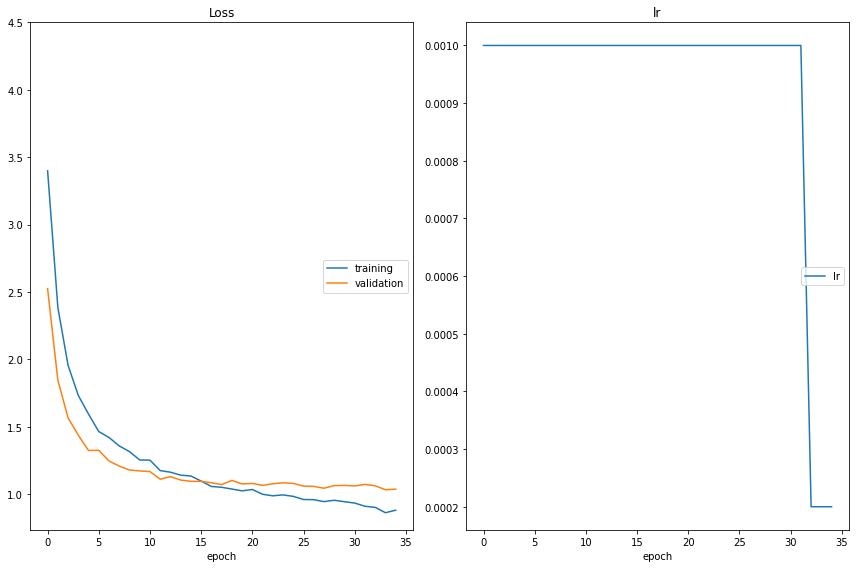

In [8]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
# === Load Transfer Learning Model ===
model_transfer = get_model_transfer_learning(model_name="resnet18", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ 

Outline of Steps Taken to Build the Final CNN Architecture
1. Start with a Simple CNN Design
Initially, I began with a basic CNN containing a few convolutional and pooling layers to validate the training pipeline. This provided a baseline for the model performance and helped identify issues early on.

2. Gradually Increased Depth and Capacity
Once the basic structure worked, I expanded the architecture to include five convolutional blocks, each followed by:

Batch Normalization: for faster convergence and regularization,

ReLU activation: introducing non-linearity, and

Max Pooling: reducing spatial dimensions and extracting dominant features.

The gradual increase in channels from 64 → 128 → 256 → 512 → 512 helps the network learn low- to high-level features progressively.

3. Added Global Average Pooling
Before the classifier, I used nn.AdaptiveAvgPool2d((1, 1)), which reduces each feature map to a single value. This:

Replaces the need for flattening large spatial maps,

Reduces overfitting,

Makes the model more robust to spatial translations.

4. Designed a Deep Classifier
The output of the feature extractor is passed through a deep fully connected classifier:

First layer: 512 → 1024

Second layer: 1024 → 512

Output layer: 512 → number of classes

Each linear layer is followed by:

Batch Normalization: to stabilize training,

ReLU: to introduce non-linearity,

Dropout (0.4): to prevent overfitting by randomly disabling neurons.

5. Trained with Regularization and Adam Optimizer
I used:

Adam optimizer with a learning rate of 0.001 for efficient convergence.

Weight decay (L2 regularization) to further reduce overfitting.

Why This Architecture is Suitable for the Problem
Image Complexity: The dataset has 50 classes and realistic images, so a deep network is justified to capture intricate features and variations across classes.

Regularization: Batch normalization and dropout reduce overfitting, especially useful given the model’s depth and complexity.

Progressive Feature Learning: The increasing channel sizes across blocks allow the model to learn progressively more abstract features.

Global Average Pooling improves generalization and reduces parameter count.

Conclusion
This architecture balances depth, capacity, and regularization. It’s inspired by proven designs like VGG and ResNet (minus residuals), making it suitable for multi-class classification problems with moderately sized datasets like ours. Given the validation loss and accuracy improvements during training, this structure is effective and well-suited for the task.



Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [9]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]

Test Loss: 0.9330
Test Accuracy: 75.12% (939/1250)


(0.9329504206776618, 75.12)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [10]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [41:26<00:00,  1.99s/it]


Accuracy: 0.7512


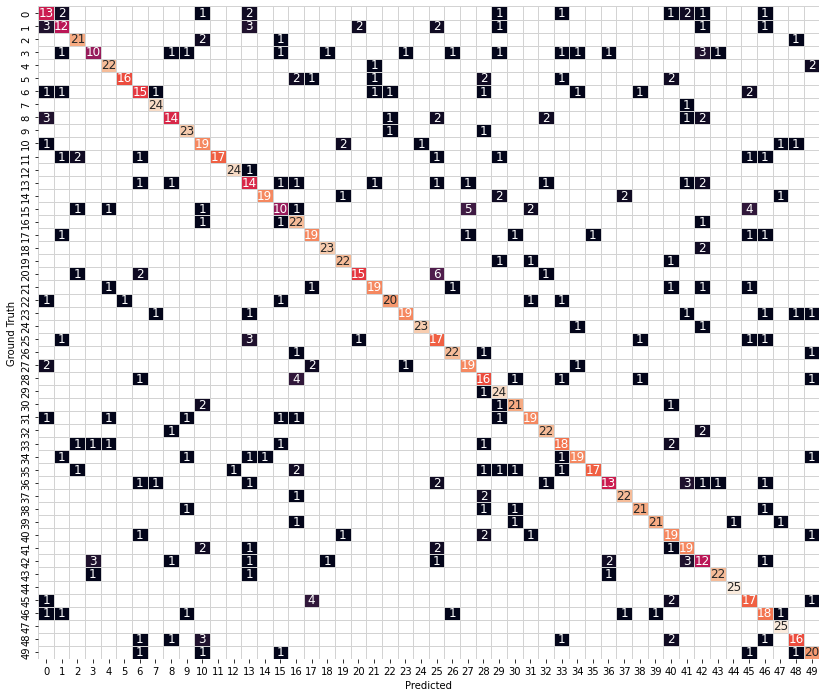

In [11]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)